In [1]:
import os
import time
import yaml
import torch
from botorch.models import SingleTaskGP
from botorch.models.transforms import Normalize, Standardize
from botorch.fit import fit_gpytorch_mll
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.acquisition import LogExpectedImprovement
from botorch.optim import optimize_acqf

import darkfield.mmmUtils_v2 as mu
from bash_config import write_bash

# Constants
N_SIM_POINTS = 1000
BOUNDS = torch.tensor([[0.0], [340.0]], dtype=torch.float64)  # microns
BOUNDS_NORMALIZED = torch.tensor([[0.0], [1.0]], dtype=torch.float64)

def generate_yaml(template_path, output_path, param_value, base_index=1):
    with open(template_path) as f:
        ip = yaml.safe_load(f)

    if param_value == 0:
        ip['O2']['in'] = 0
    else:
        ip['O2']['in'] = 1
        ip['O2']['size'] = float(param_value * 1e-6)

    filename = f"BO_{base_index}.yaml"
    fullpath = os.path.join(output_path, filename)
    with open(fullpath, 'w') as f_out:
        yaml.dump(ip, f_out, sort_keys=False)
    return filename, fullpath

def submit_job(yaml_filename, sim_index, n_sim_points=N_SIM_POINTS, n_cpus=24, mem='600GB'):
    bash_dir = '/home/yu79deg/darkfield_p5438/bash'
    bash_path = write_bash(path=bash_dir, N=n_sim_points, upd_params={'n_cpus': n_cpus, 'mem': mem, 'yaml': yaml_filename})
    os.system(f'sbatch {bash_path}')

def wait_for_completion(jobname, timeout=3600, check_interval=20):
    result_path = f'/home/yu79deg/darkfield_p5438/Aime/pickles/{jobname}_res.pickle'
    waited = 0
    while not os.path.exists(result_path) and waited < timeout:
        print(f'Waiting for job {jobname} to complete...')
        time.sleep(check_interval)
        waited += check_interval
    if not os.path.exists(result_path):
        raise TimeoutError(f'Job {jobname} did not complete in time.')
    return result_path

def extract_shadow_factor(pickle_path):
    result_data = mu.loadPickle(pickle_path)
    params = result_data[1]
    shadow = params['intensities']['roi2'] / params['intensities']['TCC']
    return shadow

def objective_function(O2_value, template_path, output_path, base_index):
    yaml_filename, _ = generate_yaml(template_path, output_path, O2_value, base_index)
    jobname = os.path.splitext(yaml_filename)[0]
    submit_job(yaml_filename, sim_index=base_index)
    result_path = wait_for_completion(jobname)
    shadow_factor = extract_shadow_factor(result_path)
    return -torch.log10(torch.tensor([[shadow_factor]], dtype=torch.float64))

def bayesian_optimization(n_iters=10, n_init=3):
    template_path = '/home/yu79deg/darkfield_p5438/yamls/BO_template.yaml'
    output_path = '/home/yu79deg/darkfield_p5438/yamls'

    # Initial random points in normalized [0,1] space
    train_x = torch.rand(n_init, 1, dtype=torch.float64)
    train_y = torch.vstack([
        objective_function(
            (x * (BOUNDS[1] - BOUNDS[0]) + BOUNDS[0]).item(),
            template_path, output_path, i+1)
        for i, x in enumerate(train_x)
    ])

    for iteration in range(n_init, n_iters):
        model = SingleTaskGP(
            train_X=train_x,
            train_Y=train_y,
            input_transform=Normalize(d=1),
            outcome_transform=Standardize(m=1)
        )
        mll = ExactMarginalLogLikelihood(model.likelihood, model)
        fit_gpytorch_mll(mll)

        # Acquisition function
        logEI = LogExpectedImprovement(model=model, best_f=train_y.max())
        candidate, _ = optimize_acqf(
            logEI, bounds=BOUNDS_NORMALIZED, q=1, num_restarts=5, raw_samples=20
        )

        new_x = candidate.detach()
        new_x_denorm = new_x * (BOUNDS[1] - BOUNDS[0]) + BOUNDS[0]
        new_y = objective_function(new_x_denorm.item(), template_path, output_path, iteration + 1)

        #print(train_x)
        #print(train_y)
        #print(new_x)
        #print(new_y)
        train_x = torch.cat([train_x, new_x])
        train_y = torch.cat([train_y, new_y])

    return train_x, train_y


In [2]:
results_x, results_y = bayesian_optimization(n_iters=40, n_init=8)

Submitted batch job 3869690
Waiting for job BO_1 to complete...
Waiting for job BO_1 to complete...
Waiting for job BO_1 to complete...
Waiting for job BO_1 to complete...
Waiting for job BO_1 to complete...
Waiting for job BO_1 to complete...
Waiting for job BO_1 to complete...
Waiting for job BO_1 to complete...
Waiting for job BO_1 to complete...
Submitted batch job 3869693
Waiting for job BO_2 to complete...
Waiting for job BO_2 to complete...
Waiting for job BO_2 to complete...
Waiting for job BO_2 to complete...
Waiting for job BO_2 to complete...
Waiting for job BO_2 to complete...
Waiting for job BO_2 to complete...
Waiting for job BO_2 to complete...
Waiting for job BO_2 to complete...
Submitted batch job 3869698
Waiting for job BO_3 to complete...
Waiting for job BO_3 to complete...
Waiting for job BO_3 to complete...
Waiting for job BO_3 to complete...
Waiting for job BO_3 to complete...
Waiting for job BO_3 to complete...
Waiting for job BO_3 to complete...
Waiting for job 

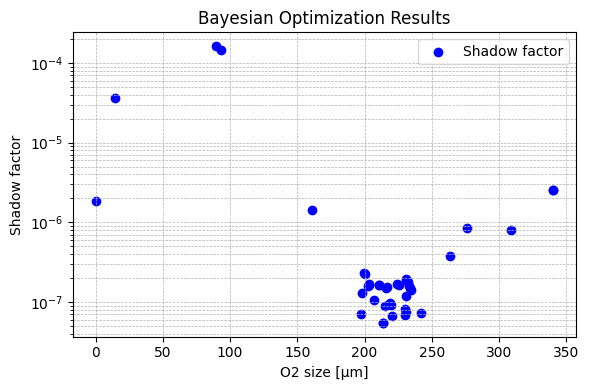

In [3]:
import matplotlib.pyplot as plt

# Denormalize inputs
denorm_x = results_x * (BOUNDS[1] - BOUNDS[0]) + BOUNDS[0]

# Convert to numpy arrays
x_vals = denorm_x.squeeze().numpy()              # O2 sizes in microns
log_y_vals = results_y.squeeze().numpy()         # -log10(shadow)
y_vals = 10**(-log_y_vals)                       # shadow factor

# Scatter plot
plt.figure(figsize=(6, 4))
plt.scatter(x_vals, y_vals, c='blue', label='Shadow factor')
plt.yscale('log')
plt.xlabel('O2 size [μm]')
plt.ylabel('Shadow factor')
plt.title('Bayesian Optimization Results')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend()
plt.tight_layout()
plt.show()
